In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.chdir('02514-Deep-Learning-In-Computer-Vision/')
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from dataloader_local import 

import matplotlib.pyplot as plt
from IPython.display import clear_output

print("Running on ", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
torch.cuda.empty_cache()

Running on  cpu


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [19]:
torch.cuda.device('cuda:0')

In [20]:
size = 128
batch_size = 6

dataset = Lesion_Data(train_transform_size=size, test_transform_size=size)
trainset, testset, validationset = dataset.get_datasets()

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=1)
print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))
print('Loaded %d validation images' % len(validationset))

Loaded 128 training images
Loaded 40 test images
Loaded 32 validation images


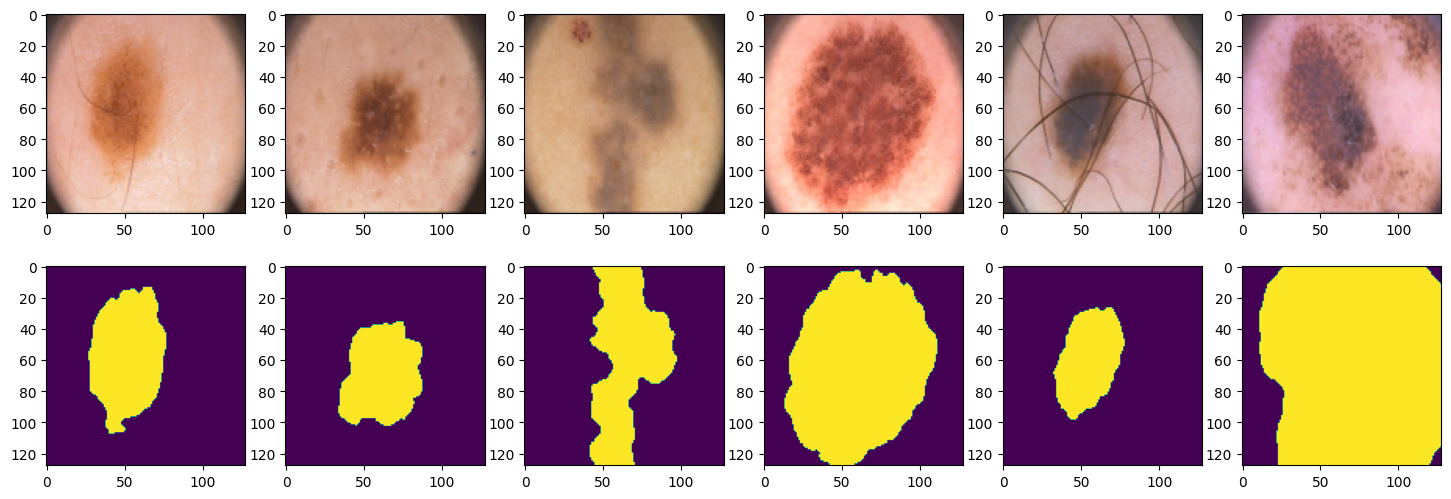

In [21]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [22]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            # loss = loss_fn(Y_batch, torch.argmax(Y_pred, dim = 1))  # forward-pass
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [23]:
def bce_loss(y_real, y_pred, clip = False):
    loss = nn.BCELoss()
    #pos_weight = torch.ones([size])
    #loss = nn.BCEWithLogitsLoss(pos_weight)
    return loss((y_pred), y_real)

In [24]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [25]:
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        d3 = torch.sigmoid(d3)
        return d3

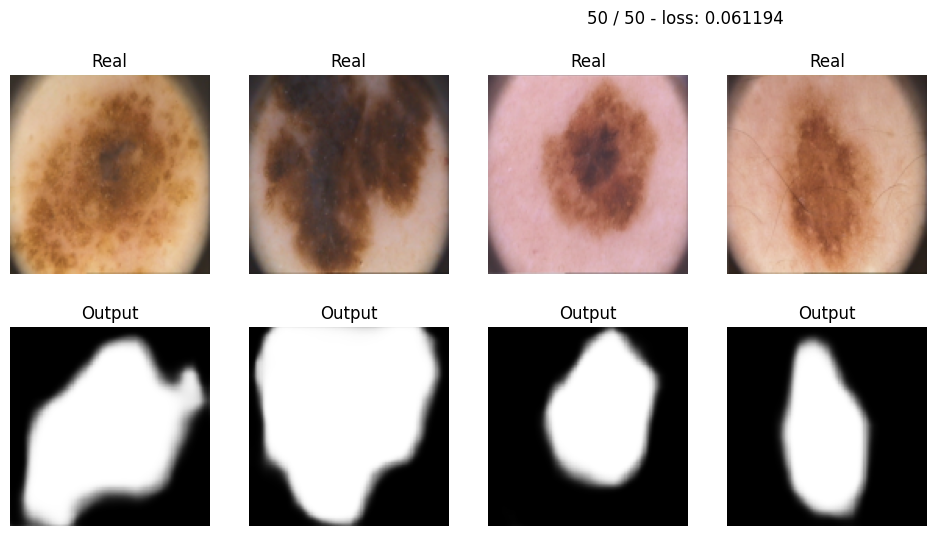

In [26]:
# Leasion | Not leasion data
model = EncDec().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 50, train_loader, test_loader)